In [1]:
import sys
sys.path.append('../src')

import torch
from torch import nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer


from helper_functions import train_step, test_step, accuracy_fn, print_train_time
from baseline_model import BaselineModel
from enhanced_model import EnhancedModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
seed = 213
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
def run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=3, silent=True):
    time_start = timer()
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Train and test model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(data_loader=cinic_train, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
            silent=silent
        )
        test_loss, test_acc = test_step(data_loader=cinic_test,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            silent=silent
        )

        # Append the metrics to the respective lists
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)

    time_end = timer()
    total_time = print_train_time(start=time_start,
                                  end=time_end,
                                  device=device)
    
    return metrics, total_time

### What I want to achieve in this notebook

train for 20 epochs 10 reruns 4 models how stable they are and if the model will overfit 


but first do it once, and plot results

In [13]:
epochs=60

In [14]:
cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)


model = BaselineModel(input_shape=3, 
    hidden_units=10, 
    output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

metrics, total_time = run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/60 [00:00<?, ?it/s]


Train time on cuda: 251.508 seconds


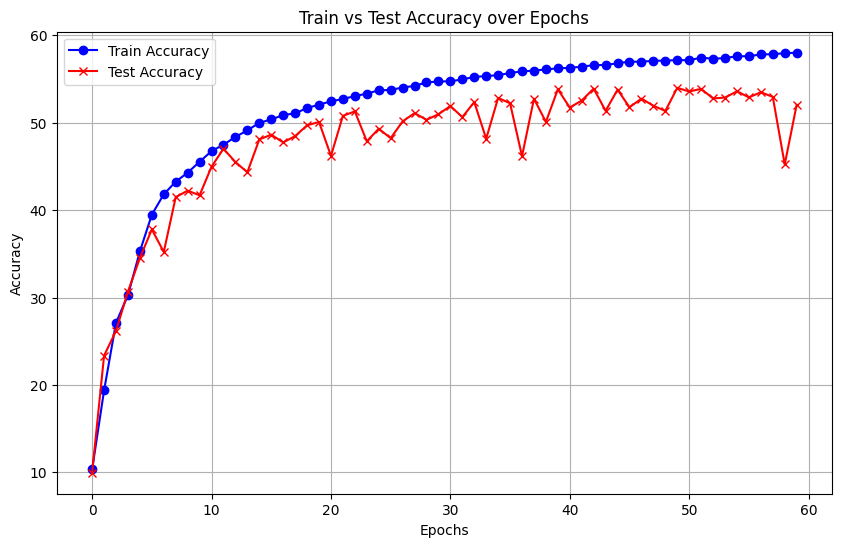

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_acc"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_acc"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)


model = EnhancedModel(input_shape=3, 
    hidden_units=32, 
    output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

metrics, total_time = run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/30 [00:00<?, ?it/s]


Train time on cuda: 162.319 seconds


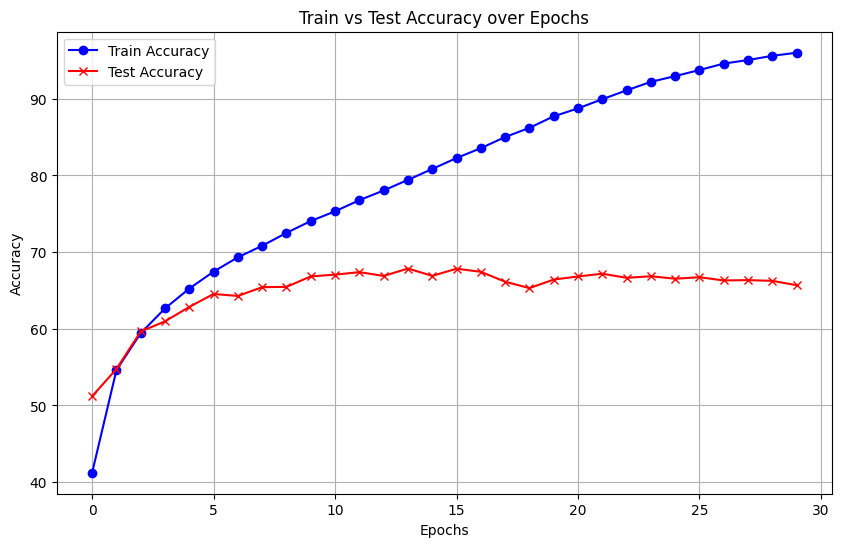

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_acc"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_acc"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

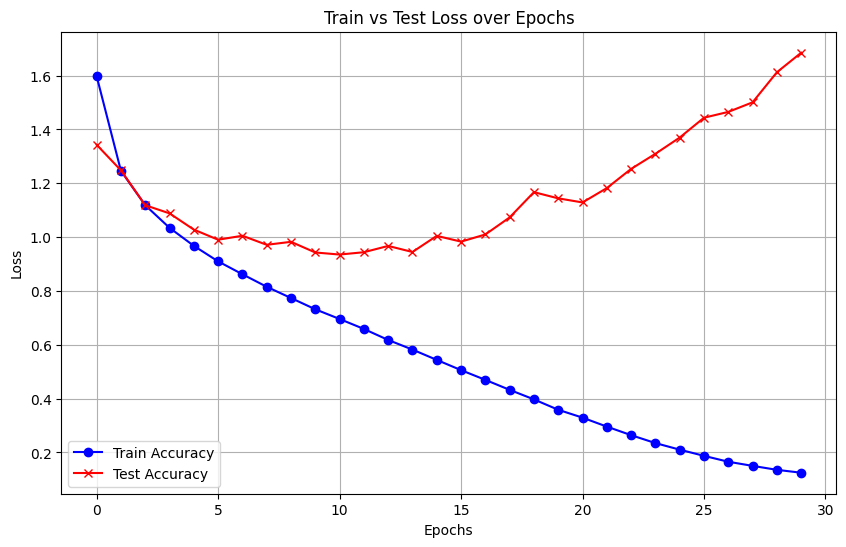

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_loss"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_loss"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

It could be improved but it does not matter we have some point of reference 